## **1: Initial Exploration (EDA)**

### Import libraries and load the dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots appear in the notebook
%matplotlib inline

In [2]:
# Load dataset (select the file from your computer)
from google.colab import files

uploaded = files.upload()  # this opens a file selector

Saving data.csv to data.csv


In [3]:
# Get the uploaded file name
filename = list(uploaded.keys())[0]

# Load the CSV into a dataframe
df = pd.read_csv(filename, encoding='ISO-8859-1')  # encoding avoids problems with accents

### Save a backup copy



In [4]:
# Back up copy
df_original = df.copy()

### First look at the dataset

In [5]:
# First 5 rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
# General info: columns, data types, missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# Basic statistics for numeric columns
df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [ ]:
# check for duplicate records
total_duplicates = df.duplicated().sum()  # Create a variable that sums all duplicate records
print(f"Total duplicate records: {total_duplicates}")  # Print using an f-string

### Column-by-column exploration

In [8]:
# Check number of unique values and missing values per column
for col in df.columns:
    print(f"Column: {col}")
    print(f" - Unique values: {df[col].nunique()}")
    print(f" - Missing values: {df[col].isnull().sum()}")
    print("-"*40)

Column: InvoiceNo
 - Unique values: 25900
 - Missing values: 0
----------------------------------------
Column: StockCode
 - Unique values: 4070
 - Missing values: 0
----------------------------------------
Column: Description
 - Unique values: 4223
 - Missing values: 1454
----------------------------------------
Column: Quantity
 - Unique values: 722
 - Missing values: 0
----------------------------------------
Column: InvoiceDate
 - Unique values: 23260
 - Missing values: 0
----------------------------------------
Column: UnitPrice
 - Unique values: 1630
 - Missing values: 0
----------------------------------------
Column: CustomerID
 - Unique values: 4372
 - Missing values: 135080
----------------------------------------
Column: Country
 - Unique values: 38
 - Missing values: 0
----------------------------------------


**What this does:**
*   nunique() → number of distinct values (good for spotting IDs vs categorical vs numerical)
*   isnull().sum() → count of missing values





In [9]:
# Preview top 5 categories per column
categorical_cols = ['StockCode','Description','Country']

for col in categorical_cols:
    print(f"Column: {col}")
    print(df[col].value_counts().head(5))  # top 5 most frequent values
    print("-"*40)

Column: StockCode
StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: count, dtype: int64
----------------------------------------
Column: Description
Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: count, dtype: int64
----------------------------------------
Column: Country
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64
----------------------------------------


Why:

* Detect most common products, countries, stock codes
* Spot strange entries like 'POST', 'C2', or empty strings




In [17]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Check range
print("Date range:")
print(df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())

Date range:
2010-12-01 08:26:00 to 2011-12-09 12:50:00


## **2: Cleaning and Transformation**

### Remove Duplicates

In [10]:
# Drop duplicates
df = df.drop_duplicates()

# Check duplicates
duplicates = df.duplicated().sum()
print(f"Total duplicates: {duplicates}")

Total duplicates: 0


### Handle Missing Values

- **Description**: we replace missing product descriptions with `"Unknown"`.  
  This way, we don’t lose transactions just because the product name is missing.  

- **CustomerID**: we decided to **keep NaN values** instead of filling them.  
  These rows most likely represent purchases made by **guest customers** (not registered with an ID).  
  Keeping them as `NaN` allows us to:
  - Preserve transaction data for sales-level analysis.  
  - Later decide if we want to group them into a `"Guest"` category when analyzing customer behavior.  


In [11]:
# Handle missing values

# Fill missing Description with 'Unknown'
df['Description'] = df['Description'].fillna('Unknown')

# Keep CustomerID missing values (NaN) as they are
# -> they represent "guest" or unidentified customers

### Convert Data Types

In [18]:
df['InvoiceDate'].dtype

dtype('<M8[ns]')

In [19]:
# Keep only the date part (day, month, year) and remove hour/min/sec
# -> useful for daily or monthly sales analysis, avoids unnecessary timestamp noise
df['InvoiceDate'] = df['InvoiceDate'].dt.floor('D')

### Create Derived Columns

In [20]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


### Returned sales

In [24]:
df["IsReturn"] = (df["Quantity"] < 0) | df["InvoiceNo"].astype(str).str.startswith("C")


### Save a backup copy


In [25]:
df_cleaned = df.copy()

## **3: Basic Analysis / Descriptive Statistics**

### Dataset-level KPIs

In [26]:
# Global KPIs
n_rows        = len(df)
n_invoices    = df["InvoiceNo"].nunique()
n_customers   = df["CustomerID"].nunique(dropna=True)
n_products    = df["StockCode"].nunique()
date_min      = df["InvoiceDate"].min()
date_max      = df["InvoiceDate"].max()

# Revenue — net (returns already negative)
net_revenue   = df["TotalPrice"].sum()

# Orders & basket metrics
order_totals  = df.groupby("InvoiceNo", as_index=False)["TotalPrice"].sum()
aov           = order_totals["TotalPrice"].mean()                       # Average Order Value
basket_items  = df.groupby("InvoiceNo")["Quantity"].sum().mean()        # Avg units per order
basket_lines  = df.groupby("InvoiceNo")["StockCode"].nunique().mean()   # Avg distinct items per order

# Returns
return_line_rate   = df["IsReturn"].mean()                              # share of lines that are returns
return_item_share  = df.loc[df["IsReturn"], "Quantity"].abs().sum() / df["Quantity"].abs().sum()

kpis = pd.DataFrame({
    "Metric": [
        "Rows", "Unique Invoices", "Unique Customers", "Unique Products",
        "Date Range (min)", "Date Range (max)",
        "Net Revenue (GBP)", "Average Order Value (GBP)",
        "Avg Units per Order", "Avg Distinct Items per Order",
        "Return Line Rate", "Return Item Share"
    ],
    "Value": [
        n_rows, n_invoices, n_customers, n_products,
        date_min, date_max,
        net_revenue, aov,
        basket_items, basket_lines,
        return_line_rate, return_item_share
    ]
})
kpis

,Metric,Value
0,Rows,536641
1,Unique Invoices,25900
2,Unique Customers,4372
3,Unique Products,4070
4,Date Range (min),2010-12-01 00:00:00
5,Date Range (max),2011-12-09 00:00:00
6,Net Revenue (GBP),9726006.954
7,Average Order Value (GBP),375.521504
8,Avg Units per Order,199.324402
9,Avg Distinct Items per Order,20.510618


#### Some Quick Insights from KPIs

- **Rows vs. Invoices**: ~537k rows but only ~25.9k invoices → each invoice has many lines. This indicates that many customers are wholesalers buying in bulk.

- **Average Order Value (~£376)**: Quite high for retail. Suggests wholesale behavior, with customers placing large orders.

- **Avg Units per Order (~199)** and **Avg Distinct Items per Order (~20)**: Both values are very large compared to typical consumer e-commerce baskets (usually 2–5 items). This reinforces the wholesale pattern.

- **Returns**: About **2% of lines** are returns, but they account for **~8% of total units**. When customers return, they often return large volumes.

- **Net Revenue (~£9.7M)**: Strong baseline metric for later breakdowns (products, months, customers).

- **Time Range**: Almost a full year (Dec 2010–Dec 2011). This makes the dataset suitable for seasonality and monthly trend analysis.


### Revenue Trend (Monthly)

In [36]:
if not np.issubdtype(df["InvoiceDate"].dtype, np.datetime64):
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["InvoiceDay"]   = df["InvoiceDate"].dt.floor("D")
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").dt.to_timestamp()

pd.options.display.float_format = "{:,.2f}".format

# Monthly revenue and orders
df_monthly = (
    df.groupby("InvoiceMonth", as_index=False)
      .agg(
          revenue=("TotalPrice", "sum"),
          orders=("InvoiceNo", "nunique"),
          customers=("CustomerID", pd.Series.nunique)
      )
      .sort_values("InvoiceMonth")
)

df_monthly.head()


,InvoiceMonth,revenue,orders,customers
0,2010-12-01,"746,723.61",2025,948
1,2011-01-01,"558,448.56",1476,783
2,2011-02-01,"497,026.41",1393,798
3,2011-03-01,"682,013.98",1983,1020
4,2011-04-01,"492,367.84",1744,899


#### Quick Note
- Revenue peaks in December 2010 (holiday season), then falls in January–February.  
- March shows recovery, consistent with seasonal retail patterns.  


### Top Products by Revenue

In [37]:
# Top 10 products by revenue
df_top_products = (
    df.groupby(["StockCode", "Description"], as_index=False)
      .agg(revenue=("TotalPrice", "sum"))
      .sort_values("revenue", ascending=False)
      .head(10)
)

df_top_products


,StockCode,Description,revenue
5736,DOT,DOTCOM POSTAGE,"206,245.48"
1931,22423,REGENCY CAKESTAND 3 TIER,"164,459.49"
3877,47566,PARTY BUNTING,"98,243.88"
5100,85123A,WHITE HANGING HEART T-LIGHT HOLDER,"97,659.94"
5068,85099B,JUMBO BAG RED RETROSPOT,"92,175.79"
2811,23084,RABBIT NIGHT LIGHT,"66,661.63"
5740,POST,POSTAGE,"66,230.64"
1545,22086,PAPER CHAIN KIT 50'S CHRISTMAS,"63,715.24"
4759,84879,ASSORTED COLOUR BIRD ORNAMENT,"58,792.42"
4168,79321,CHILLI LIGHTS,"53,746.66"


### Top Customers by Revenue

In [38]:
# Top 10 customers by revenue
df_top_customers = (
    df.dropna(subset=["CustomerID"])
      .groupby("CustomerID", as_index=False)
      .agg(revenue=("TotalPrice", "sum"))
      .sort_values("revenue", ascending=False)
      .head(10)
)

df_top_customers


,CustomerID,revenue
1703,"14,646.00","279,489.02"
4233,"18,102.00","256,438.49"
3758,"17,450.00","187,322.17"
1895,"14,911.00","132,458.73"
55,"12,415.00","123,725.45"
1345,"14,156.00","113,214.59"
3801,"17,511.00","88,125.38"
3202,"16,684.00","65,892.08"
1005,"13,694.00","62,690.54"
2192,"15,311.00","59,284.19"


### Country Breakdown

In [39]:
# Revenue by country (excluding UK for visibility, optional)
df_country = (
    df.groupby("Country", as_index=False)
      .agg(revenue=("TotalPrice", "sum"))
      .sort_values("revenue", ascending=False)
)

df_country.head(10)

,Country,revenue
36,United Kingdom,"8,167,128.18"
24,Netherlands,"284,661.54"
10,EIRE,"262,993.38"
14,Germany,"221,509.47"
13,France,"197,317.11"
0,Australia,"137,009.77"
33,Switzerland,"56,363.05"
31,Spain,"54,756.03"
3,Belgium,"40,910.96"
32,Sweden,"36,585.41"


### Histogram of Order Values

In [40]:
# Order totals (for histogram)
df_orders = (
    df.groupby("InvoiceNo", as_index=False)
      .agg(order_value=("TotalPrice", "sum"))
)

df_orders.describe()


,order_value
count,"25,900.00"
mean,375.52
std,"2,012.63"
min,"-168,469.60"
25%,11.78
50%,206.31
75%,407.38
max,"168,469.60"


#### Quick Insights on Order Values

- **Highly skewed distribution**: Median order is only ~£206, while the mean is ~£376. A few massive invoices pull the average up.  
- **Extreme outliers**: Orders range from -£168k (returns) to +£168k, showing huge wholesale transactions.  
- **Bulk orders dominate**: 75% of orders are under ~£407, but the long tail of very large invoices defines the revenue profile.  


## 4: **Visualization**

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

### Monthly Revenue Trend (lineplot)

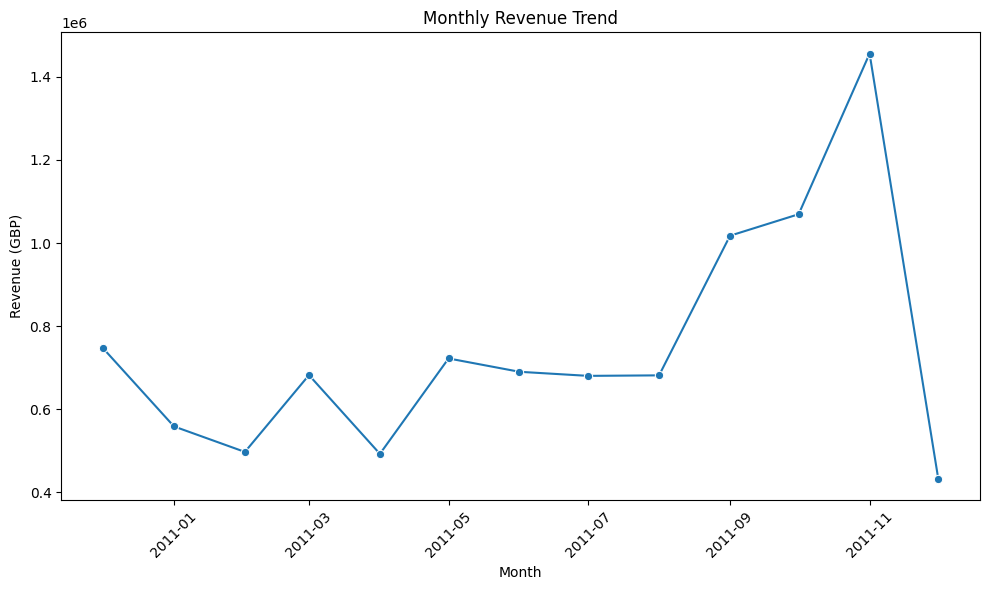

In [46]:
# ensure figures folder exists
Path("figures").mkdir(exist_ok=True)

plt.figure(figsize=(10,6))
sns.lineplot(data=df_monthly, x="InvoiceMonth", y="revenue", marker="o")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue (GBP)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/monthly_revenue.png")
plt.show()

#### Monthly Revenue Insights

- **Strong seasonality**: December 2010 and November 2011 show the biggest peaks, consistent with holiday shopping cycles.  
- **Mid-year stability**: From May to August 2011, revenue is relatively flat, hovering around £680k.  
- **Sharp end-of-year drop**: December 2011 looks artificially low due to incomplete data (dataset ends on Dec 9).  


### Top 10 Products by Revenue (barplot)

/tmp/ipython-input-3769685671.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


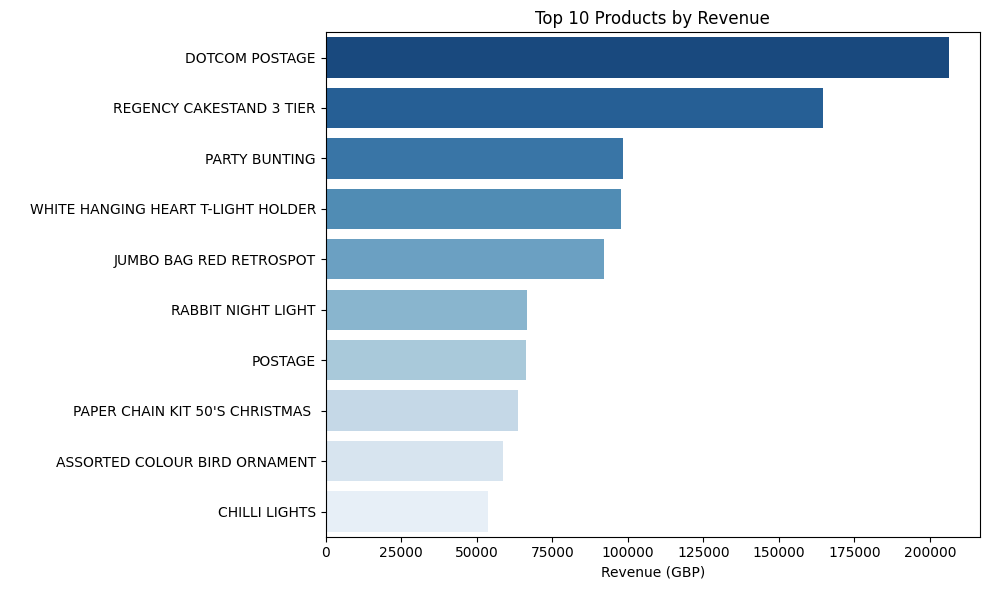

In [49]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_top_products,
    x="revenue",
    y="Description",
    palette="Blues_r"
)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue (GBP)")
plt.ylabel(" ")
plt.tight_layout()
plt.savefig("figures/top_products.png")
plt.show()


#### Product Revenue Insights

- **High concentration**: The top 2 products ("DOTCOM POSTAGE" and "REGENCY CAKESTAND 3 TIER") dominate sales, each generating well above £150k.  
- **Gift-oriented items**: Many best-sellers (e.g., bunting, tea-light holders, ornaments) are decorative, aligning with the “all-occasion gifts” context of the retailer.  
- **Long tail**: The lower half of the top 10 contributes significantly less, showing a steep revenue drop after the leaders.  


### Top 10 Customers by Revenue (barplot)

/tmp/ipython-input-1257278439.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


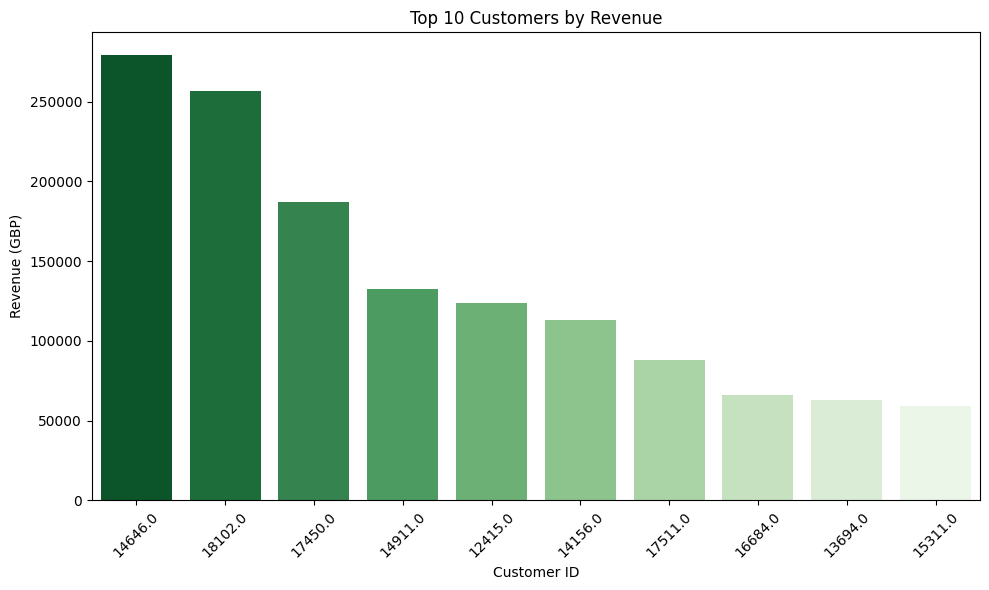

In [53]:
# Sort by revenue descending
df_top_customers_sorted = df_top_customers.sort_values("revenue", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_top_customers_sorted,
    x="CustomerID",
    y="revenue",
    palette="Greens_r",
    order=df_top_customers_sorted["CustomerID"]   # enforce custom order
)
plt.title("Top 10 Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Revenue (GBP)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/top_customers_sorted.png")
plt.show()


#### Customer Revenue Insights

- Revenue is **highly concentrated**: a handful of customers drive the majority of sales.  
- The top customer alone exceeds **£280k**, far above the median among the top 10.  
- The distribution is **skewed**, with no “normal” spread — a few large buyers dominate, while most customers contribute much less.  


### Revenue by Country (barplot)

/tmp/ipython-input-2133460932.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


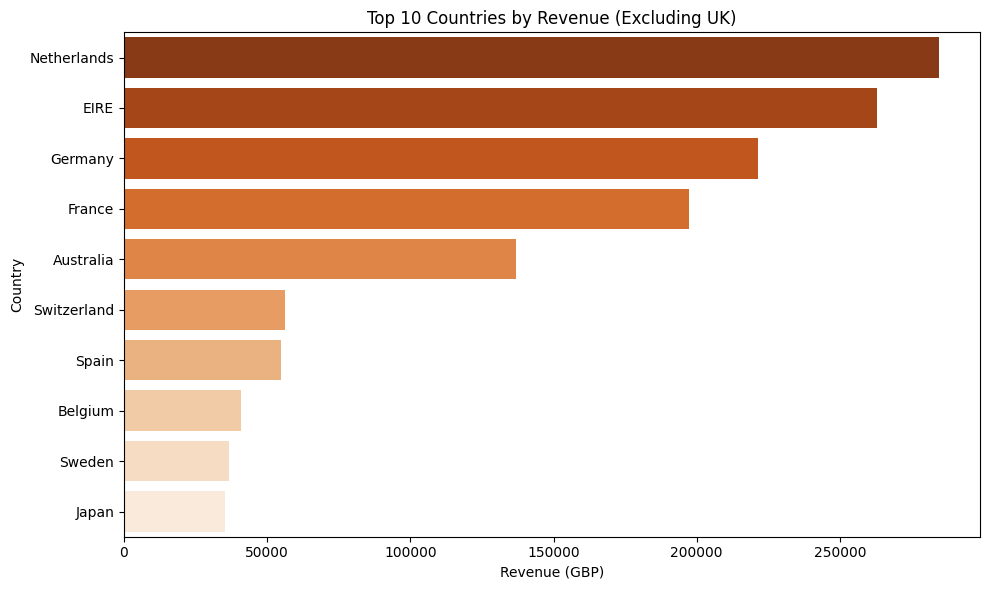

In [54]:
# exclude UK for better visibility of others
df_country_nonuk = df_country[df_country["Country"] != "United Kingdom"].head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_country_nonuk,
    x="revenue",
    y="Country",
    palette="Oranges_r"
)
plt.title("Top 10 Countries by Revenue (Excluding UK)")
plt.xlabel("Revenue (GBP)")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig("figures/top_countries.png")
plt.show()


#### Country Revenue Insights

- **Netherlands and Ireland lead** international sales, each contributing well over £250k in revenue.  
- **Germany and France** follow closely, confirming strong presence across Western Europe.  
- Non-European markets like **Australia and Japan** appear in the top 10 but at much smaller scales, highlighting the retailer’s primarily European focus.  


### Distribution of Order Values (histogram)

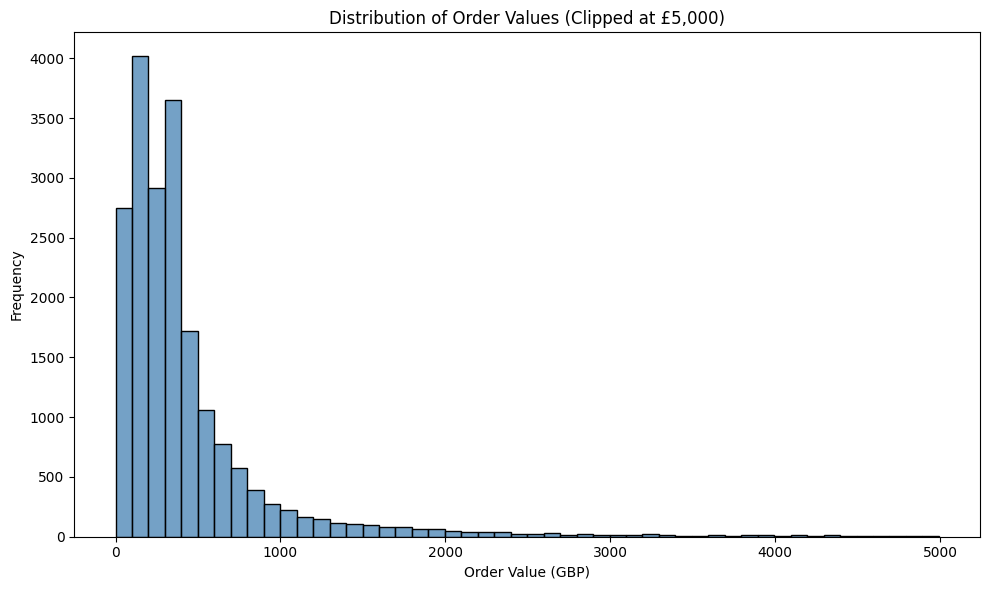

In [58]:
plt.figure(figsize=(10,6))

# Keep only positive orders under 5000 GBP
filtered_orders = df_orders[(df_orders["order_value"] > 0) & (df_orders["order_value"] < 5000)]

sns.histplot(filtered_orders["order_value"], bins=50, kde=False, color="steelblue")
plt.title("Distribution of Order Values (Clipped at £5,000)")
plt.xlabel("Order Value (GBP)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/order_value_hist_clean.png")
plt.show()



#### Order Value Distribution Insights

- **Heavily right-skewed**: Most orders are below £500, with frequency dropping sharply as value increases.  
- **Long tail**: A smaller number of orders reach into the thousands, showing wholesale bulk purchases.  
- **Clipping clarifies**: By excluding extreme outliers, the main retail pattern becomes visible — frequent small-to-medium orders dominate the dataset.  


## **5: Insights and Conclusions**

The analysis of this UK e-commerce dataset (2010–2011) reveals several actionable patterns:

- **Seasonality matters**: December is the clear revenue peak, driven by holiday shopping, while January–February show sharp drops. Planning for demand spikes in Q4 is critical for inventory and logistics.  

- **Product concentration**: A handful of SKUs (e.g., postage services, cake stands, decorative items) generate disproportionate revenue. This highlights the need for tight assortment management and promotion of proven top sellers.  

- **Customer dependence**: A small group of wholesale buyers accounts for a large share of revenue. While profitable, this creates dependency risk — diversifying the customer base or nurturing mid-tier accounts could reduce exposure.  

- **Geographic footprint**: Although the UK dominates, continental Europe (Netherlands, Ireland, Germany, France) contributes strongly. Non-European markets are present but marginal. Expanding international distribution could unlock new growth.  

- **Order structure**: Most baskets are small in value (<£500), but a long tail of bulk orders drives the average up. Returns represent ~8% of units, which suggests reviewing return policies and customer quality control.  

### Actionable Takeaways
1. **Forecasting**: Build seasonal demand forecasts to optimize stock levels, especially for Q4 surges.  
2. **Merchandising**: Focus on best-performing products while experimenting with adjacent categories to broaden appeal.  
3. **Customer strategy**: Develop retention plans for top buyers while expanding outreach to medium-sized customers.  
4. **International growth**: Prioritize expansion in strong European markets, while testing scalability in non-EU geographies.  
5. **Returns management**: Investigate drivers of large-scale returns and strengthen controls to protect margins.  

Overall, the dataset confirms a wholesale-oriented business with seasonal peaks, concentrated revenue sources, and clear opportunities to optimize both product and customer strategies.